# Ancestral Descent Classification Model

This notebook encapsulates the cleaning, data augmentation, modelling and hyperparameter tuning of the Ancestral Descent Classification Model. A summary of the following steps are as follows:

**1. Usage of Deepface pre-trained model from [Deepface](https://github.com/serengil/deepface) library.**
* A pre-trained model that has a hybrid facial recognition framework with commonly used models e.g VGGFace, FaceNet, OpenFace
* DeepFace can also perform facial recognition, facial verification tasks to a high degree of accuracy > 97%.
* Facial Attribute Analysis can also be done, which is used as preliminary analysis of facial images. 
* Age model got ± 4.65 MAE; gender model got 97.44% accuracy, 96.29% precision and 95.05% recall 
* Caveat that model was trained on western data/faces and faces available in the public domain. 

**2. Sharpening of Images**
* This is done via a pre-set kernal to ensure greater extraction of facial features from given image


**3. Ancestral Descent Classification Model**
* This will be based on ethnicities found more predominantly in Singapore, with a more signficant breakdown among Asian ethnicities while focusing all western, middle-eastern, black and hispanic identities into the "Others" category.
* Data Augmentation of current images was done
* Data Cleaning of image labels was conducted
* Modelling via RandomForestClassifier was conducted via MultiOutputClassifier
* Hyperparameter Tuning was conducted
* Classification Report and Performance Metrics were analysed

# Importing of Libraries

This step is to import all of the basic libraries used in this ancestral descent model.

In [2]:
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.preprocessing import image
import cv2
import matplotlib.pyplot as plt
import json
import math
from PIL import Image
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# Using Deepface Pre-trained model



__[Deepface] (https://github.com/serengil/deepface)__ is a lightweight face recognition and facial attribute analysis (age, gender, emotion and race) framework for python. It is a hybrid face recognition framework wrapping state-of-the-art models: VGG-Face, Google FaceNet, OpenFace, Facebook DeepFace, DeepID, ArcFace, Dlib and SFace.

Experiments show that human beings have 97.53% accuracy on facial recognition tasks whereas those models already reached and passed that accuracy level.

In [4]:
from deepface import DeepFace

Directory  C:\Users\rusta /.deepface created
Directory  C:\Users\rusta /.deepface/weights created


In [15]:
#Sample filepath is used
img_path = "..\Capstone Photos\Local_Families\L005\MID6\img5.jpg"

In [16]:
#read image in
img = cv2.imread(img_path)

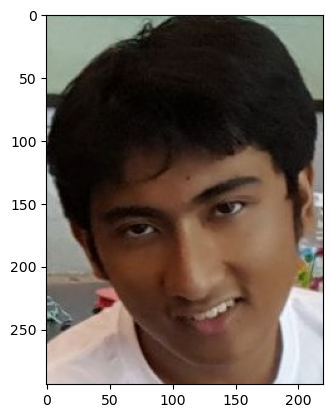

In [18]:
#show image, if image is bluish, means RGB is reversed. Use following code to reverse it.
plt.imshow(img[:, :, ::-1])

From this image, a few faults can be seen in regards to ambiguity in terms of age, race and emotion. However, this analysis serves a rudimentary, perfunctory function which can further explored with more data to localise models further.

In [19]:
#extracting out key attributes of image from DeepFace
demography = DeepFace.analyze(img_path, 
                actions = ['age', 'gender', 'race', 'emotion'])

Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


In [45]:
#provides messy summary of analyzed image
print(type(demography))
demography

<class 'list'>


[{'emotion': {'angry': 1.197879839764937e-06,
   'disgust': 1.8624956178020513e-10,
   'fear': 0.0003518666972013307,
   'happy': 99.98703002929688,
   'sad': 8.109799409794505e-05,
   'surprise': 4.158236208695598e-05,
   'neutral': 0.01249152555828914},
  'dominant_emotion': 'happy',
  'region': {'x': 24, 'y': 94, 'w': 171, 'h': 171},
  'age': 22,
  'gender': {'Woman': 0.10312716476619244, 'Man': 99.89687204360962},
  'dominant_gender': 'Man',
  'race': {'asian': 40.99594056606293,
   'indian': 28.783264756202698,
   'black': 12.688291072845459,
   'white': 1.8610861152410507,
   'middle eastern': 1.6889732331037521,
   'latino hispanic': 13.982449471950531},
  'dominant_race': 'asian'}]

In [48]:
demo_dict = demography[0]
print(type(demo_dict))

#Transforming demographic data into a dictionary
demo_dict

<class 'dict'>


{'emotion': {'angry': 1.197879839764937e-06,
  'disgust': 1.8624956178020513e-10,
  'fear': 0.0003518666972013307,
  'happy': 99.98703002929688,
  'sad': 8.109799409794505e-05,
  'surprise': 4.158236208695598e-05,
  'neutral': 0.01249152555828914},
 'dominant_emotion': 'happy',
 'region': {'x': 24, 'y': 94, 'w': 171, 'h': 171},
 'age': 22,
 'gender': {'Woman': 0.10312716476619244, 'Man': 99.89687204360962},
 'dominant_gender': 'Man',
 'race': {'asian': 40.99594056606293,
  'indian': 28.783264756202698,
  'black': 12.688291072845459,
  'white': 1.8610861152410507,
  'middle eastern': 1.6889732331037521,
  'latino hispanic': 13.982449471950531},
 'dominant_race': 'asian'}

In [49]:
#Simple extraction of data
d_age = demo_dict["age"]
d_race = demo_dict["dominant_race"]
print(f"Image's age: {d_age} and race: {d_race}")

Age: 22 and Race: asian


In [1]:
#creating function to automate process
def human_data_extraction(img_path, details):
    #read image
    img = cv2.imread(img_path)
    
    # show image
    plt.imshow(img[:, :, ::-1])
    
    # use DeepFace to analyze attributes
    #extracting out key attributes of image from DeepFace
    demo = DeepFace.analyze(img_path)
    
    #transform list into dictionary
    demo_dict = demo[0]
    
    print("Image Details:")
    #print out details in list
    for detail in details:
        x = demo_dict[detail]
        print(f"{detail.capitalize()}: {x}")    

# Creating Facial Verification Model

This is necessary to ensure uploaded images are properly verified images before proceeding to next steps. Facial recognition models not only detect faces but also crop images to size to properly extract facial embeddings. Face detection and alignment are important early stages of a modern face recognition pipeline. Experiments show that just alignment increases the face recognition accuracy almost 1%.

Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.34it/s]

Image Details:
Age: 22
Dominant_gender: Man
Dominant_emotion: happy
Dominant_race: asian


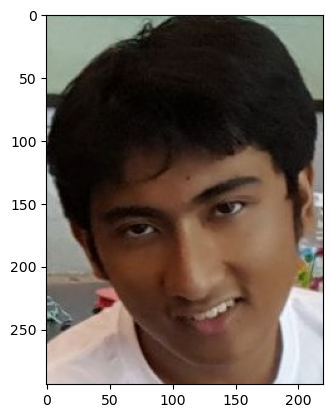

In [53]:
attributes = ["age", "dominant_gender", "dominant_emotion", "dominant_race"]

human_data_extraction(img_path = "..\Capstone Photos\Local_Families\L005\MID6\img5.jpg", details = attributes)

# Facial Alignment

Model to change model alignment even if the face is tilted. Retinaface is tried.

In [73]:
from retinaface import RetinaFace

image = "..\Capstone Photos\Local_Families\L005\MID6\img5.jpg"

In [74]:
# returns facial area coordinates and some landmarks
resp = RetinaFace.detect_faces(img_path)
resp

{'face_1': {'score': 0.976033627986908,
  'facial_area': [49, 105, 191, 280],
  'landmarks': {'right_eye': [77.8237, 175.20657],
   'left_eye': [142.10474, 158.95422],
   'nose': [114.70928, 213.51038],
   'mouth_right': [97.86244, 234.47324],
   'mouth_left': [159.26334, 220.75531]}}}

In [295]:
#images = "./test_group_photo.jpg"
images = "..\Capstone Photos\Local_Families\L005\MID6\img5.jpg"

faces = RetinaFace.extract_faces(img_path = images, align = True) #returns object of class list

for face in faces:
    print(type(face))
    print(face.shape)
    plt.imshow(face)
    plt.show()

<class 'numpy.ndarray'>
(175, 142, 3)


In [296]:
#images = "./test_group_photo.jpg"
images = "..\Capstone Photos\Local_Families\L005\MID6\img5.jpg"

faces = RetinaFace.extract_faces(img_path = images, align = True) #returns object of class list

face = faces[0]

print(type(face))
print(face.shape)
#plt.imshow(face)
#plt.show()
print(face)

<class 'numpy.ndarray'>
(175, 142, 3)
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


# Sharpening image

Using a preset kernal, facial features can be sharpened to allow for more accurate facial embeddings to be extracted, allowing for greater accuracy of facial analysis.

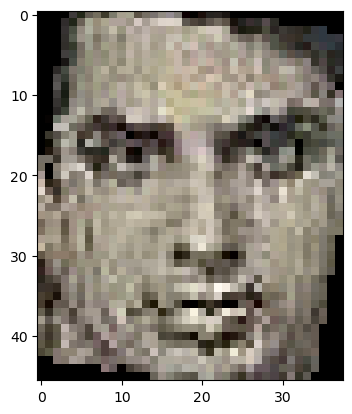

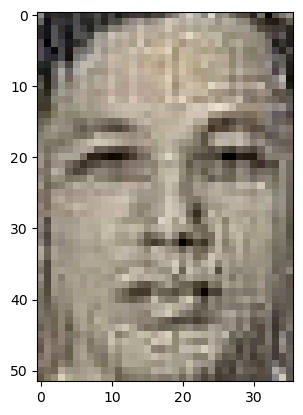

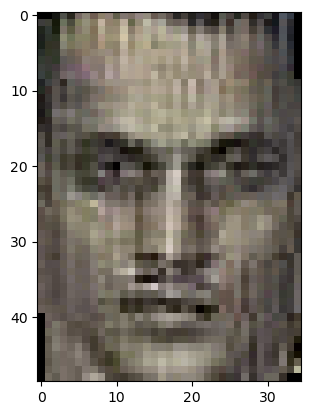

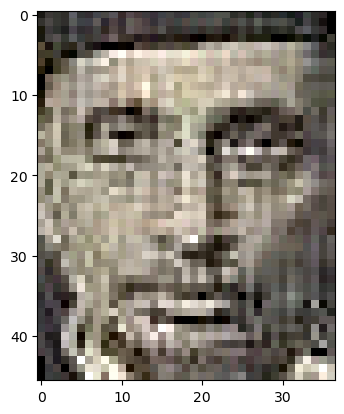

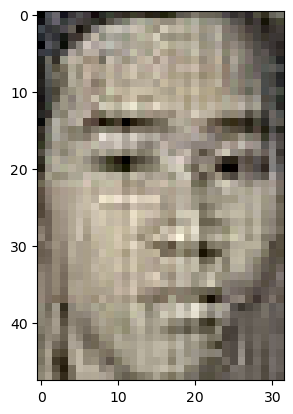

In [88]:
# Create the sharpening kernel 
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 
  
# Sharpen the image 
cv_image = cv2.imread(images) 


sharpened = cv2.filter2D(cv_image, -1, kernel) 
#sharpened = cv2.GaussianBlur(cv_image, (7, 7), 0) 

faces = RetinaFace.extract_faces(img_path = sharpened, align = True)
for face in faces:
    plt.imshow(face)
    plt.show()

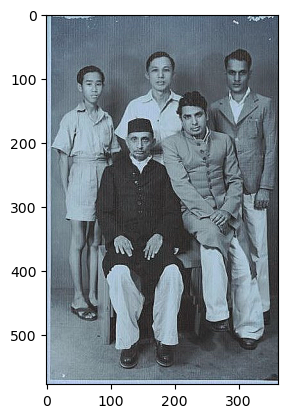

In [89]:
plt.imshow(sharpened[:, :, ::-1])
plt.show()

# Model for Multiclass, Multi-label classifier for Ethnicity

Based on the current model on DeepFace, it is not detailed enough to provide the in-detailed analysis that we are looking for. Hence, a classifier that aims to predict the genetic inheritance of a particular individual was created.

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgba2rgb

C:\Users\rusta\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Data Cleaning of Image Labels

Basic Cleaning of .xlsx file was conducted. Classification Model will be binary, hence NaN values are converted to 0 and 1.0 as integer 1 respectively. The model will serve to predict if the image depicts a facial image that has ancestral lineage from these separate ethnic groups. 

In [4]:
# Load the CSV file containing the ancestry descent information
data = pd.read_excel("./genetic_ancestry.xlsx")
data.head()

,Unnamed: 0,Cambodian,Indonesian,Malay,Tamil,Telugu,Punjabi,Bengali,Gujarati,South Han,North Han,Japanese,Others,Total
0,HJ,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
1,BR,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,4.0
2,ZI,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,4.0
3,FZ,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,4.0
4,JN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,4.0


In [5]:
#Cleaning data 
clean_data = data.fillna(0).drop("Total", axis=1).rename(columns = {'Unnamed: 0':'image_filename'})
clean_data.head()

,image_filename,Cambodian,Indonesian,Malay,Tamil,Telugu,Punjabi,Bengali,Gujarati,South Han,North Han,Japanese,Others
0,HJ,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BR,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
2,ZI,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,FZ,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,JN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [6]:
# Create a dictionary to map image filenames to their corresponding labels
image_labels = {row['image_filename']: row.iloc[1:].to_list() for _, row in clean_data.iterrows()}
image_labels

{'HJ': [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'BR': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0],
 'ZI': [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0],
 'FZ': [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0],
 'JN': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0],
 'PV': [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 'AG': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 'MG': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0],
 'SS': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0],
 'AA': [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 'WG': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0],
 'JH': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0],
 'RG': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0],
 'TG': [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0],
 'Z1': [1.0, 1.0, 1.0, 1.0, 0.0, 1

# Data Augmentation

This step is critical to upsample undersampled classes as well to create more training data to allow for more robust training as well as testing. This is done to increase the sample size of images overall. 

In [323]:
# Define the data folder and output folder
data_folder = "Model_Photos" #folder that exists
output_folder = "ADM_test" #empty folder to store generated image data

In [334]:
# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Make sure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Iterate through the images in the data folder and generate augmented images
for files in os.listdir(data_folder):
    
    print(f"Currently in folder {files}")
    
    list_of_specimens = os.path.join(data_folder, files) 
    
    for image in os.listdir(list_of_specimens):
        
        print(f"Currently looking at image {image}")

        if image.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            image_path = os.path.join(list_of_specimens, image)
            img = tf.keras.preprocessing.image.load_img(image_path)
            x = tf.keras.preprocessing.image.img_to_array(img)
            x = x.reshape((1,) + x.shape)

            i = 0
            for batch in datagen.flow(x, batch_size=1):
                augmented_image = tf.keras.preprocessing.image.array_to_img(batch[0])
                
                file_name, file_extension = os.path.splitext(image)
                generated_image_name = f"{files}_{file_name}_{i}{file_extension}"
                
                augmented_image.save(os.path.join(output_folder, generated_image_name))
                
                #Save image 
                additional_path = "Model_Photos/" + files
                augmented_image.save(os.path.join(additional_path, generated_image_name))
                
                i += 1
                if i >= 20:  # Generate a maximum of 20 augmented images per original image
                    break

print("Augmentation complete.")


Currently in folder AA
Currently looking at image img1.png
Currently looking at image img2.png
Currently in folder AG
Currently looking at image img1.png
Currently looking at image img2.png
Currently in folder AS
Currently looking at image img1.jpg
Currently looking at image img2.png
Currently looking at image img3.png
Currently in folder BR
Currently looking at image img1.png
Currently looking at image img2.png
Currently looking at image img3.png
Currently in folder FZ
Currently looking at image img1.png
Currently looking at image img2.png
Currently looking at image img3.png
Currently in folder HJ
Currently looking at image img1.jpg
Currently looking at image img2.jpg
Currently looking at image img3.jpg
Currently in folder JH
Currently looking at image img1.png
Currently looking at image img2.png
Currently in folder JN
Currently looking at image img1.png
Currently looking at image img2.png
Currently in folder MG
Currently looking at image img1.png
Currently looking at image img2.png
C

# Creation of Model Labels and Images

In order to fit images into model, flattening is used. Flattening is a technique that is used to convert multi-dimensional arrays into a 1-D array, it is generally used in Deep Learning while feeding the 1-D array information to the classification model.

This is due to the fact that multi-dimensional arrays take more amount of memory while 1-D arrays take less memory, which is the most important reason why we flatten the Image Array before processing/feeding the information to our model.

In [30]:
# Initialize lists to store images, labels, and unique person IDs
X = []
y = []
person_ids = []

In [31]:
#Original
# Load and preprocess the images from the image folder
image_folder = 'Model_Photos'
count = 0
specimen = []

# Create input data (X) by loading and preprocessing the images from the image folder
for image_filename in os.listdir(image_folder):
    genetic_specimen = os.path.join(image_folder, image_filename)  #image_path is folder of each folder with images inside
    
    for images in os.listdir(genetic_specimen):
        
        image_path = os.path.join(genetic_specimen, images) 
            
        image = cv2.imread(image_path) #products object of type <class 'numpy.ndarray'>
            
        #if have 4 channels, which means has alpha channel
        if image.shape[-1] == 4:
            image = rgba2rgb(image) #convert to 3 channels


        image = resize(image, (224, 224), anti_aliasing=True)
        
        #creating X array
        X.append(image.flatten()) #Need to flatten image
        count +=1
        specimen.append(image_filename)

print(f"There are {count} images in total")
print(f"This is the order of the photos: {specimen} ")

There are 1281 images in total
This is the order of the photos: ['AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AG', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'AS', 'BR', 'BR', 'BR', 'BR', 'BR', 'BR', 'BR', 'BR', 'BR',

In [35]:
#Match every image to genetic info
genetic_info = clean_data.set_index(clean_data.columns[0])

df = genetic_info.loc[specimen, :]
df.head()

,Cambodian,Indonesian,Malay,Tamil,Telugu,Punjabi,Bengali,Gujarati,South Han,North Han,Japanese,Others
image_filename,,,,,,,,,,,,
AA,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
AA,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
AA,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
AA,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
AA,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


# Preliminary Analysis of labels was conducted to determine breakdown of genetic facial population collected and augmented.

From this analysis, it is determined that 12 lables may not accurately determine undersampled groups accurately. 

In [414]:
#Count sum of total of each column
df.sum()

Cambodian      798.0
Indonesian     756.0
Malay          861.0
Tamil          588.0
Telugu          63.0
Punjabi        693.0
Bengali        588.0
Gujarati       525.0
South Han      924.0
North Han     1050.0
Japanese       735.0
Others        1176.0
dtype: float64

#### Grouping the different ethnicities under bigger, umbrella terms would increase sampling power, hence it is done as such. Further modelling will determine which labelling will have greater accuracy.

In [36]:
#transformation of data into compiled groups of 6
df_few = df
columns_to_drop = df.columns
df_few["Mainland SEA"] = df_few["Cambodian"].astype(int)
df_few["Archipelago SEA"] = [1 if row['Malay'] == 1.0 or row['Indonesian'] == 1.0 else 0 for index, row in df.iterrows()]
df_few["Han Chinese"] = [1 if row['South Han'] == 1.0 or row['North Han'] == 1.0 else 0 for index, row in df.iterrows()]
df_few["South Indian"] = [1 if row['Tamil'] == 1.0 or row['Telugu'] == 1.0 else 0 for index, row in df.iterrows()]
df_few["North Indian"] = [1 if row['Punjabi'] == 1.0 or row['Bengali'] == 1.0 or row["Gujarati"] == 1.0 else 0 for index, row in df.iterrows()]
df_few["All Others"] = [1 if row['Japanese'] == 1.0 or row['Others'] == 1.0 else 0 for index, row in df.iterrows()]
df_few = df_few.drop(columns = columns_to_drop, axis=1)
df_few.head()

,Mainland SEA,Archipelago SEA,Han Chinese,South Indian,North Indian,All Others
image_filename,,,,,,
AA,1,1,0,0,1,1
AA,1,1,0,0,1,1
AA,1,1,0,0,1,1
AA,1,1,0,0,1,1
AA,1,1,0,0,1,1


# Transformation of Data into inputs for model

This involves binarizing vectors in ancestry and also ensuring reshaping image data into 2D array. 



## Usage of 12 Ethnic group lables for classification

In [57]:
# Create output data (y) by extracting the ancestry labels from the Excel columns
ancestry_columns = df.columns  # Exclude the first column with image filenames
y = df[ancestry_columns].to_numpy().astype(int) #convert into array of integers of 1 and 0s
y

array([[1, 0, 1, ..., 0, 1, 1],
       [1, 0, 1, ..., 0, 1, 1],
       [1, 0, 1, ..., 0, 1, 1],
       ...,
       [0, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1]])

## Usage of 6 Ethnic group lables for classification

In [37]:
# Create output data (y) by extracting the ancestry labels from the Excel columns
ancestry_columns = df_few.columns  # Exclude the first column with image filenames
y = df_few[ancestry_columns].to_numpy().astype(int) #convert into array of integers of 1 and 0s
y

array([[1, 1, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 1],
       ...,
       [0, 1, 1, 0, 0, 1],
       [0, 1, 1, 0, 0, 1],
       [0, 1, 1, 0, 0, 1]])

In [38]:
# Check the dimensions of the images
image_shapes = [img.shape for img in X]

# Ensure that all images have the same dimensions
if not all(shape == image_shapes[0] for shape in image_shapes):
    print("Not all images have the same dimensions. Please ensure all images have the same dimensions.")
else:
    print("All images are same dims. Congratulations. Please proceed to next step.")

All images are same dims. Congratulations. Please proceed to next step.


In [39]:
# Reshape the input data into a #D Numpy array
X = np.array(X)
y = np.array(y)

# Modelling process

Using Pycaret, it was found that there was no significant differences in performance and runtimes.

In [393]:
# Create a multi-class, multi-label classifier
clf = MultiOutputClassifier(LogisticRegression(max_iter=100))

In [396]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 12 Class Labels Model

In [370]:
# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Get the class names (ancestry group names)
class_names = ancestry_columns

# Print overall accuracy
print("Accuracy = ", accuracy_score(y_test, y_pred))

# Print the classification report
print(classification_report(y_test, y_pred, target_names=class_names))

Accuracy =  0.2178988326848249
              precision    recall  f1-score   support

  Indonesian       0.70      0.79      0.74       141
       Malay       0.74      0.83      0.78       162
       Tamil       0.55      0.63      0.59       103
      Telugu       0.83      0.77      0.80        13
     Punjabi       0.63      0.74      0.68       117
     Bengali       0.55      0.63      0.59       103
    Gujarati       0.53      0.59      0.56        90
   South Han       0.86      0.83      0.84       184
   North Han       0.88      0.91      0.89       215
    Japanese       0.67      0.74      0.70       134
      Others       0.91      0.96      0.94       228

   micro avg       0.74      0.80      0.77      1490
   macro avg       0.71      0.77      0.74      1490
weighted avg       0.74      0.80      0.77      1490
 samples avg       0.74      0.82      0.73      1490



# 6 Class Labels Model

In [395]:
# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Get the class names (ancestry group names)
class_names = ancestry_columns

# Print overall accuracy
print("Accuracy = ", accuracy_score(y_test, y_pred))

# Print the classification report
print(classification_report(y_test, y_pred, target_names=class_names))

Accuracy =  0.35019455252918286
                 precision    recall  f1-score   support

Archipelago SEA       0.74      0.83      0.78       162
    Han Chinese       0.88      0.91      0.89       215
   South Indian       0.55      0.63      0.59       103
   North Indian       0.63      0.74      0.68       117
     All Others       0.91      0.96      0.94       228

      micro avg       0.78      0.85      0.81       825
      macro avg       0.74      0.81      0.78       825
   weighted avg       0.79      0.85      0.82       825
    samples avg       0.78      0.85      0.77       825



# Sandbox using Random Forest + Hyperparameter tuning

Hyperparameter tuning took about 3 hours to complete. Overall, best Hyperparameters are determined to be:

{'estimator__max_depth': None, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200} 

Classification Report:
                 precision    recall  f1-score   support

Archipelago SEA       0.80      1.00      0.89       162
    Han Chinese       0.93      1.00      0.96       215
   South Indian       0.87      0.86      0.87       103
   North Indian       0.82      0.97      0.89       117
     All Others       0.90      1.00      0.94       228

      micro avg       0.87      0.98      0.92       825
      macro avg       0.86      0.97      0.91       825
   weighted avg       0.87      0.98      0.92       825
    samples avg       0.86      0.98      0.90       825

In [406]:
#Try Number 2 with hyperparameter tuning of LogRegression:

# Define the hyperparameter grid for the base estimator (e.g., RandomForestClassifier)
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    # Add more hyperparameters as needed
}

# Create a MultiOutputClassifier with your base estimator (e.g., RandomForestClassifier)
base_estimator = RandomForestClassifier()  # Replace with your choice of classifier
multi_output_clf = MultiOutputClassifier(base_estimator)

# Create a GridSearchCV instance
grid_search = GridSearchCV(
    multi_output_clf,
    param_grid,
    cv=5,  # Number of cross-validation folds
    verbose=2,  # Increase verbosity for more information
    n_jobs=-1  # Utilize multiple CPU cores for faster processing
)

# Fit the GridSearchCV object to your training data
grid_search.fit(X_train, y_train)

# Access the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# You can now use the best estimator for making predictions on your test data.
y_pred = best_estimator.predict(X_test)

# Print the best hyperparameters and the classification report
print("Best Hyperparameters:", best_params)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'estimator__max_depth': None, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200}
Classification Report:
                 precision    recall  f1-score   support

Archipelago SEA       0.80      1.00      0.89       162
    Han Chinese       0.93      1.00      0.96       215
   South Indian       0.87      0.86      0.87       103
   North Indian       0.82      0.97      0.89       117
     All Others       0.90      1.00      0.94       228

      micro avg       0.87      0.98      0.92       825
      macro avg       0.86      0.97      0.91       825
   weighted avg       0.87      0.98      0.92       825
    samples avg       0.86      0.98      0.90       825



# For this model, Precision and Recall were focused instead of Accuracy.

This is due to the fact that accuracy refers to predicted true over all true. However, with a multioutput classifier, it is quite common for a few labels to be predicted incorrectly. 


## Precision

Ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The best value is 1 and the worst value is 0.

## Recall

Recall, also known as the true positive rate (TPR), is the percentage of data samples that a machine learning model correctly identifies as belonging to a class of interest—the “positive class”—out of the total samples for that class.

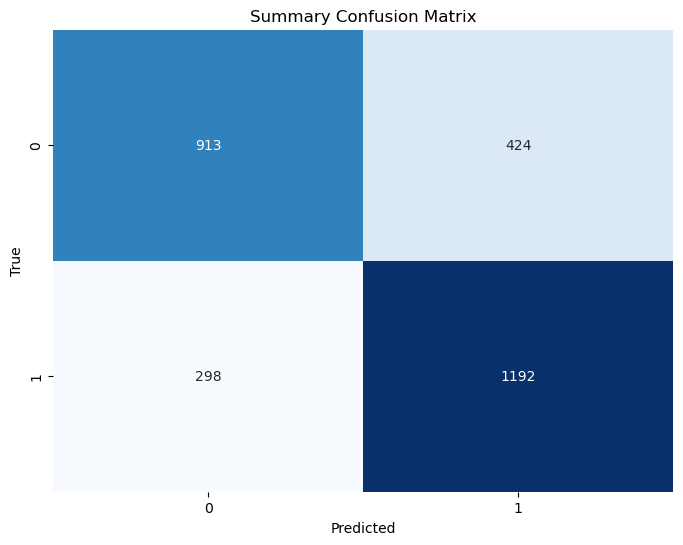

In [372]:
# Calculate multilabel confusion matrices
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Create a single summary confusion matrix
summary_confusion_matrix = mcm.sum(axis=0)  # Aggregate confusion matrices

# Visualize the summary confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(summary_confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Summary Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

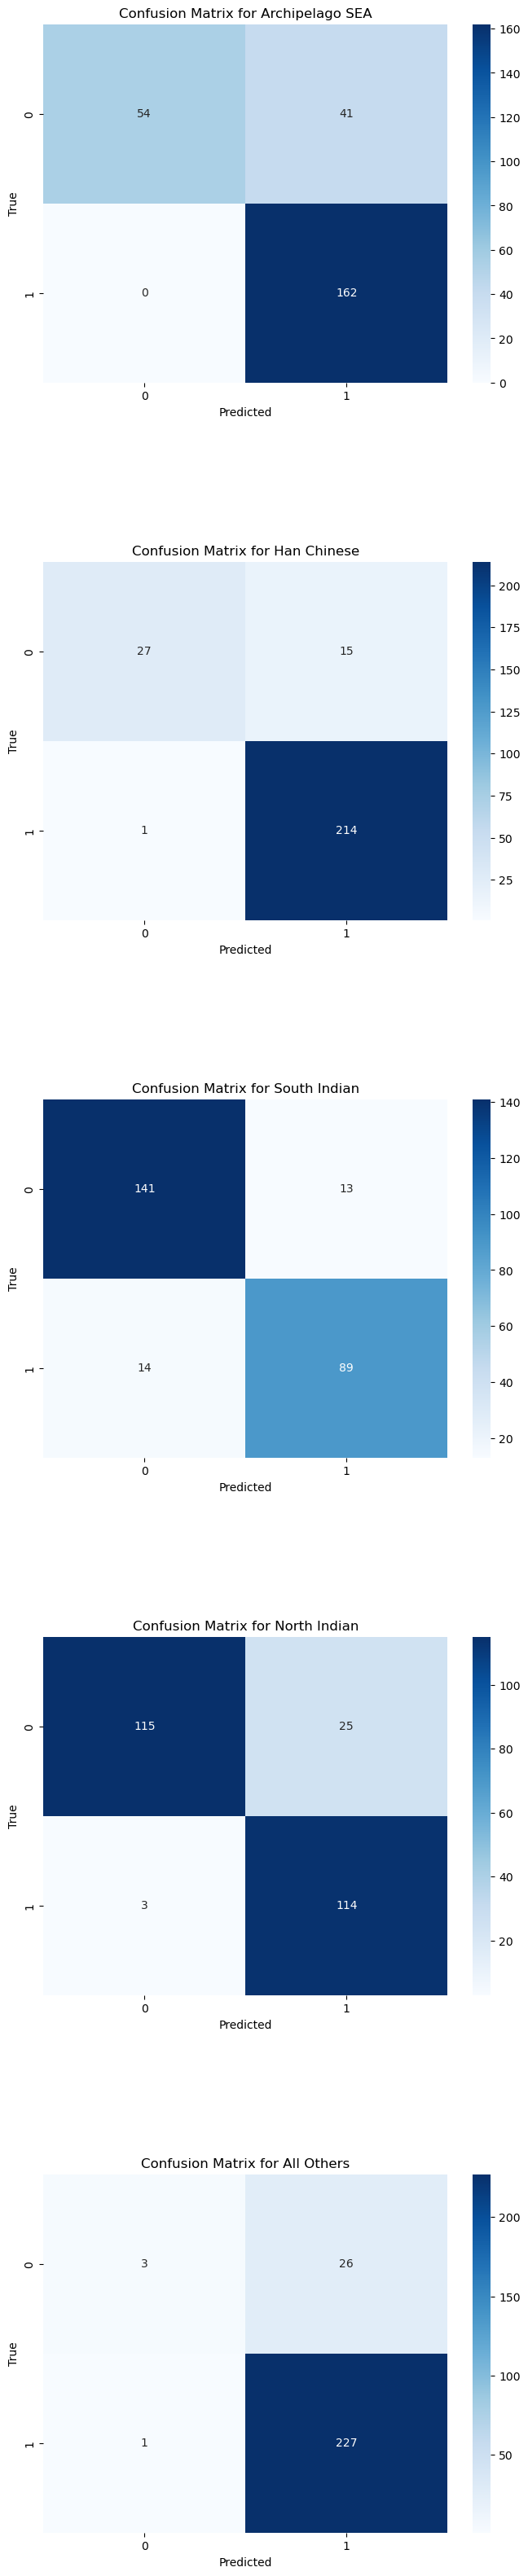

In [422]:
# Calculate the confusion matrix
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
n_classes = len(class_names)
fig, axes = plt.subplots(n_classes, 1, figsize=(8, 8 * n_classes))
plt.subplots_adjust(hspace=0.5)


for i in range(n_classes):
    ax = axes[i]
    sns.heatmap(mcm[i], annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f'Confusion Matrix for {class_names[i]}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.show()

In [ ]:
# Create a multi-class multi-output classifier
clf = MultiOutputClassifier(LogisticRegression())

# Fit the model to the data
clf.fit(X, y)

# Make predictions
y_pred = clf.predict_proba(X)

# Get the class names
class_names = ... # List of class names


# Print the class name and prediction probabilities

for i in range(len(y_pred)):
    print(f"Class name: {class_names[i]}")
    print(f"Prediction probability: {y_pred[i]}")

# Final model for saving to .pickl file

* Based on hyperparameter tuning where we fit 5 folds for each of 36 candidates, totalling 180 fits. 
* The best Hyperparameters: {'estimator__max_depth': None, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200}

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Create a MultiOutputClassifier with your base estimator (e.g., RandomForestClassifier)
base_estimator = RandomForestClassifier(max_depth = None, 
                                        min_samples_split = 2, 
                                        n_estimators = 200)  # Replace with your choice of classifier

multi_output_clf = MultiOutputClassifier(base_estimator)

In [42]:
multi_output_clf.fit(X_train, y_train) 
y_pred = multi_output_clf.predict(X_test) 

In [43]:
# Get the class names (ancestry group names)
class_names = ancestry_columns

print(classification_report(y_test, y_pred, target_names=class_names))

                 precision    recall  f1-score   support

   Mainland SEA       0.83      0.95      0.89       153
Archipelago SEA       0.82      1.00      0.90       162
    Han Chinese       0.94      0.99      0.96       215
   South Indian       0.88      0.84      0.86       103
   North Indian       0.84      0.97      0.90       117
     All Others       0.89      1.00      0.94       228

      micro avg       0.87      0.97      0.92       978
      macro avg       0.87      0.96      0.91       978
   weighted avg       0.87      0.97      0.92       978
    samples avg       0.87      0.98      0.90       978



In [44]:
class_names

Index(['Mainland SEA', 'Archipelago SEA', 'Han Chinese', 'South Indian',
       'North Indian', 'All Others'],
      dtype='object')

In [45]:
# Print overall accuracy
print("Accuracy = ", accuracy_score(y_test, y_pred))

Accuracy =  0.5914396887159533


In [46]:
import pickle

In [47]:
pickle.dump(multi_output_clf , open('racist-model.pk1' , 'wb'))

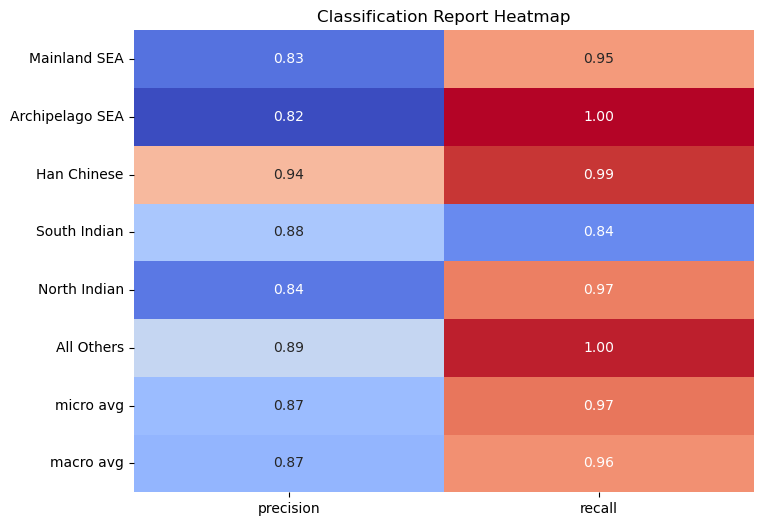

In [54]:
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

# Convert the classification report to a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-2, :-2], annot=True, cmap="coolwarm", fmt='.2f', cbar=False)
plt.title('Classification Report Heatmap')
plt.show()